# Lead Scoring for Teamlink - Data Science Project

This notebook outlines the steps and code used to load, clean, analyze, and calculate lead scores for users in the Teamlink dataset.

## 1. Load Datasets

In [2]:

import pandas as pd

# Load datasets
users_df = pd.read_csv('users.csv')
properties_df = pd.read_csv('properties.csv')
inspections_df = pd.read_csv('inspections.csv')
enhanced_website_interactions_df = pd.read_csv('enhanced_website_interactions.csv')
crm_interactions_df = pd.read_csv('crm_interactions.csv')
agents_df = pd.read_csv('agents.csv')
sales_df = pd.read_csv('sales.csv')


In [23]:
datasets = [users_df, properties_df, inspections_df, enhanced_website_interactions_df,crm_interactions_df, agents_df, sales_df]


for i in datasets:
    print("Dataset")
    print(i.columns)

Dataset
Index(['user_id', 'name', 'email', 'phone', 'age', 'gender', 'location',
       'neighborhood', 'postcode', 'income_level', 'family_status'],
      dtype='object')
Dataset
Index(['property_id', 'property_name', 'property_type', 'address',
       'neighborhood', 'postcode', 'location', 'price', 'size_sqft',
       'bedrooms', 'bathrooms', 'floors', 'year_built', 'property_condition',
       'balcony', 'garden', 'swimming_pool', 'garage', 'furnished',
       'property_tags', 'developer_id', 'availability_status', 'listing_date',
       'description'],
      dtype='object')
Dataset
Index(['Property ID', 'Agent ID', 'Name', 'Company', 'Email Address',
       'Phone Number', 'Zip Code', 'Address', 'City', 'State', 'Suburb',
       'Latitude', 'Longitude', 'Did you find what you were looking for',
       'Overall Condition of the Property', 'Interaction with the agent',
       'Satisfaction with the inspection process', 'Likelihood to Buy or Rent',
       'What did you like most?', '

## 2. Analyze and Summarize User Interactions

In [3]:
import  numpy as np
# Website interactions summary
website_interactions_summary = enhanced_website_interactions_df.groupby('user_id').agg(
    total_interactions=pd.NamedAgg(column='event_id', aggfunc='count'),
    properties_viewed=pd.NamedAgg(column='property_id', aggfunc=pd.Series.nunique),
    events_tracked=pd.NamedAgg(column='event_type', aggfunc=pd.Series.nunique)
)

# Inspections summary
inspections_df['user_id'] = np.random.choice(users_df['user_id'], size=len(inspections_df), replace=True)

inspections_summary = inspections_df.groupby('user_id').agg(
    total_inspections=pd.NamedAgg(column='Inspection Date', aggfunc='count'),
    unique_properties_inspected=pd.NamedAgg(column='Property ID', aggfunc=pd.Series.nunique)
)

# CRM interactions summary
crm_interactions_summary = crm_interactions_df.groupby('User ID').agg(
    total_crm_interactions=pd.NamedAgg(column='Interaction ID', aggfunc='count'),
    agents_contacted=pd.NamedAgg(column='Agent ID', aggfunc=pd.Series.nunique)
)

crm_interactions_summary.rename(columns={'User ID': 'user_id'}, inplace=True)

# Merge summaries with user data
users_lead_summary = users_df.merge(website_interactions_summary, on='user_id', how='left').merge(inspections_summary, on='user_id', how='left').merge(crm_interactions_summary, left_on='user_id', right_index=True, how='left')

users_lead_summary.fillna(0, inplace=True)


## 3. Include Property Tags and Inspection Ratings

In [4]:

# Mapping property tags to users based on property interactions
user_property_tags = enhanced_website_interactions_df.merge(properties_df[['property_id', 'property_tags']], 
                                                            on='property_id', how='left')

# Aggregating the property tags for each user
user_property_tags_summary = user_property_tags.groupby('user_id').agg(
    most_frequent_tags=pd.NamedAgg(column='property_tags', aggfunc=lambda x: x.mode()[0] if not x.mode().empty else 'None'),
    unique_tags_viewed=pd.NamedAgg(column='property_tags', aggfunc=pd.Series.nunique)
)

# Merge property tags summary with users_lead_summary
users_lead_summary = users_lead_summary.merge(user_property_tags_summary, on='user_id', how='left')
users_lead_summary['most_frequent_tags'].fillna('None', inplace=True)
users_lead_summary['unique_tags_viewed'].fillna(0, inplace=True)

# Converting categorical ratings to numeric
condition_mapping = {'Excellent': 5, 'Good': 4, 'Fair': 3, 'Poor': 2, 'Very Poor': 1}
satisfaction_mapping = {'Very Satisfied': 5, 'Satisfied': 4, 'Neutral': 3, 'Unsatisfied': 2, 'Very Unsatisfied': 1}

inspections_df['Overall Condition of the Property'] = inspections_df['Overall Condition of the Property'].map(condition_mapping)
inspections_df['Satisfaction with the inspection process'] = inspections_df['Satisfaction with the inspection process'].map(satisfaction_mapping)

# Aggregating inspection ratings
inspection_features = inspections_df.groupby('user_id').agg(
    most_liked_feature=pd.NamedAgg(column='What did you like most?', aggfunc=lambda x: x.mode()[0] if not x.mode().empty else 'None'),
    avg_condition_rating=pd.NamedAgg(column='Overall Condition of the Property', aggfunc='mean'),
    avg_agent_interaction_rating=pd.NamedAgg(column='Interaction with the agent', aggfunc='mean'),
    avg_inspection_satisfaction=pd.NamedAgg(column='Satisfaction with the inspection process', aggfunc='mean'),
    avg_likelihood_to_buy=pd.NamedAgg(column='Likelihood to Buy or Rent', aggfunc='mean')
)

# Merge inspection features with users_lead_summary
users_lead_summary = users_lead_summary.merge(inspection_features, on='user_id', how='left')
users_lead_summary['most_liked_feature'].fillna('None', inplace=True)
users_lead_summary[['avg_condition_rating', 'avg_agent_interaction_rating', 'avg_inspection_satisfaction', 'avg_likelihood_to_buy']].fillna(0, inplace=True)


C:\Users\shiva\AppData\Local\Temp\ipykernel_40148\344963855.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  users_lead_summary['most_frequent_tags'].fillna('None', inplace=True)
C:\Users\shiva\AppData\Local\Temp\ipykernel_40148\344963855.py:14: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behave

In [6]:
users_lead_summary.sample(20)

,user_id,name,email,phone,age,gender,location,neighborhood,postcode,income_level,...,unique_properties_inspected,total_crm_interactions,agents_contacted,most_frequent_tags,unique_tags_viewed,most_liked_feature,avg_condition_rating,avg_agent_interaction_rating,avg_inspection_satisfaction,avg_likelihood_to_buy
193,194,Jeremy English,rrodgers@example.net,947-245-0940x48364,52,Female,"Sydney, Sydney CBD, 2000",Sydney CBD,2000,Low,...,2.0,0.0,0.0,None,0.0,Bedrooms,2.500000,4.000000,4.000000,5.000000
462,463,Joshua Garza,carladams@example.com,001-366-378-9489x20422,40,Male,"Sydney, Manly, 2095",Manly,2095,Medium,...,1.0,0.0,0.0,Affordable,1.0,"Neighborhood, Bathrooms, Bedrooms",3.000000,2.000000,5.000000,2.000000
304,305,Melvin Gay,susandelacruz@example.com,(833)821-1540x5812,60,Male,"Sydney, Manly, 2095",Manly,2095,High,...,2.0,1.0,1.0,None,0.0,Garage,3.000000,2.500000,3.500000,2.000000
367,368,Jennifer Freeman,jesse11@example.net,001-884-693-3318x143,59,Female,"Sydney, Bondi Beach, 2026",Bondi Beach,2026,High,...,1.0,0.0,0.0,Affordable,2.0,"Bathrooms, Balcony, Price",4.000000,5.000000,2.000000,3.000000
405,406,David Miller,stacy51@example.com,629.326.2758x2267,52,Female,"Sydney, Darlinghurst, 2010",Darlinghurst,2010,Medium,...,1.0,0.0,0.0,None,0.0,"Bedrooms, Price, Kitchen",4.000000,5.000000,4.000000,1.000000
349,350,George Thompson,lisagrant@example.com,727-881-1931x6621,41,Male,"Sydney, Chatswood, 2067",Chatswood,2067,Low,...,1.0,1.0,1.0,Investment,3.0,"Bathrooms, Living Space",5.000000,4.000000,3.000000,2.000000
248,249,Kimberly Phillips,stephaniemoore@example.org,562.581.9973,26,Male,"Sydney, North Sydney, 2060",North Sydney,2060,High,...,3.0,2.0,2.0,Luxury,3.0,Balcony,3.000000,3.666667,2.333333,3.666667
159,160,Bryan Smith,tracy45@example.org,261.946.0539x8965,53,Male,"Sydney, Sydney CBD, 2000",Sydney CBD,2000,Medium,...,3.0,0.0,0.0,None,0.0,"Bathrooms, Balcony",3.666667,3.333333,3.666667,3.000000
23,24,Henry Roberson,steveleblanc@example.com,362.655.9568,23,Male,"Sydney, Paddington, 2021",Paddington,2021,Low,...,1.0,1.0,1.0,Affordable,3.0,"Living Space, Balcony, Kitchen",1.000000,2.000000,3.000000,1.000000
132,133,Rebecca Bush,alexandra84@example.org,(813)301-8608x71990,37,Male,"Sydney, Newtown, 2042",Newtown,2042,High,...,2.0,1.0,1.0,None,0.0,"Bedrooms, Kitchen, Balcony",2.000000,5.000000,3.000000,3.500000


## 4. Calculate Lead Scores

In [8]:

# Define the weights for each scoring category
weights = {
    'total_interactions': 10,
    'properties_viewed': 10,
    'events_tracked': 5,
    'total_inspections': 20,
    'unique_properties_inspected': 15,
    'avg_condition_rating': 10,
    'avg_agent_interaction_rating': 5,
    'avg_inspection_satisfaction': 5,
    'avg_likelihood_to_buy': 15,
    'total_crm_interactions': 15,
    'agents_contacted': 10,
    'unique_tags_viewed': 5,
}

# Normalize scores and apply weights
users_lead_summary['engagement_score'] = (
    users_lead_summary['total_interactions'] * weights['total_interactions'] +
    users_lead_summary['properties_viewed'] * weights['properties_viewed'] +
    users_lead_summary['events_tracked'] * weights['events_tracked']
)

users_lead_summary['inspection_score'] = (
    users_lead_summary['total_inspections'] * weights['total_inspections'] +
    users_lead_summary['unique_properties_inspected'] * weights['unique_properties_inspected'] +
    users_lead_summary['avg_condition_rating'] * weights['avg_condition_rating'] +
    users_lead_summary['avg_agent_interaction_rating'] * weights['avg_agent_interaction_rating'] +
    users_lead_summary['avg_inspection_satisfaction'] * weights['avg_inspection_satisfaction'] +
    users_lead_summary['avg_likelihood_to_buy'] * weights['avg_likelihood_to_buy']
)

users_lead_summary['crm_score'] = (
    users_lead_summary['total_crm_interactions'] * weights['total_crm_interactions'] +
    users_lead_summary['agents_contacted'] * weights['agents_contacted']
)

users_lead_summary['property_preference_score'] = (
    users_lead_summary['unique_tags_viewed'] * weights['unique_tags_viewed']
)

# Calculate the total lead score
users_lead_summary['total_lead_score'] = (
    users_lead_summary['engagement_score'] +
    users_lead_summary['inspection_score'] +
    users_lead_summary['crm_score'] +
    users_lead_summary['property_preference_score']
)

# Normalize the total lead score to a range of 0-100
users_lead_summary['total_lead_score'] = (
    100 * (users_lead_summary['total_lead_score'] / users_lead_summary['total_lead_score'].max())
)

# The final lead summary with calculated scores
users_lead_summary.head()


,user_id,name,email,phone,age,gender,location,neighborhood,postcode,income_level,...,most_liked_feature,avg_condition_rating,avg_agent_interaction_rating,avg_inspection_satisfaction,avg_likelihood_to_buy,engagement_score,inspection_score,crm_score,property_preference_score,total_lead_score
0,1,Mark White,gwilliams@example.com,722.304.7352x481,20,Male,"Sydney, Chatswood, 2067",Chatswood,2067,Medium,...,Kitchen,5.0,5.0,4.0,2.5,15.0,202.5,0.0,0.0,29.096990
1,2,Gregory Woodard,jamesstewart@example.net,(992)358-3215x5170,45,Female,"Sydney, Paddington, 2021",Paddington,2021,High,...,Balcony,4.0,3.5,4.0,1.5,0.0,170.0,40.0,0.0,28.093645
2,3,Stephanie Wood,jthomas@example.com,(285)640-7191x3046,46,Male,"Sydney, Darlinghurst, 2010",Darlinghurst,2010,Medium,...,"Bathrooms, Living Space",3.0,3.4,2.6,2.6,200.0,274.0,25.0,15.0,68.762542
3,4,Kristy Barnes,scott27@example.com,001-978-385-4013x71362,47,Male,"Sydney, Newtown, 2042",Newtown,2042,Low,...,"Garage, Bedrooms",5.0,3.0,1.0,1.0,180.0,120.0,0.0,15.0,42.140468
4,5,Tammy Smith,gparker@example.net,+1-971-895-5457x889,30,Male,"Sydney, Newtown, 2042",Newtown,2042,Medium,...,"Price, Living Space",5.0,3.0,1.0,4.0,115.0,165.0,0.0,5.0,38.127090


In [9]:
users_lead_summary.to_csv("User_lead_summary.csv", index=False)

# Visualizations

In [10]:
import matplotlib.pyplot as plt

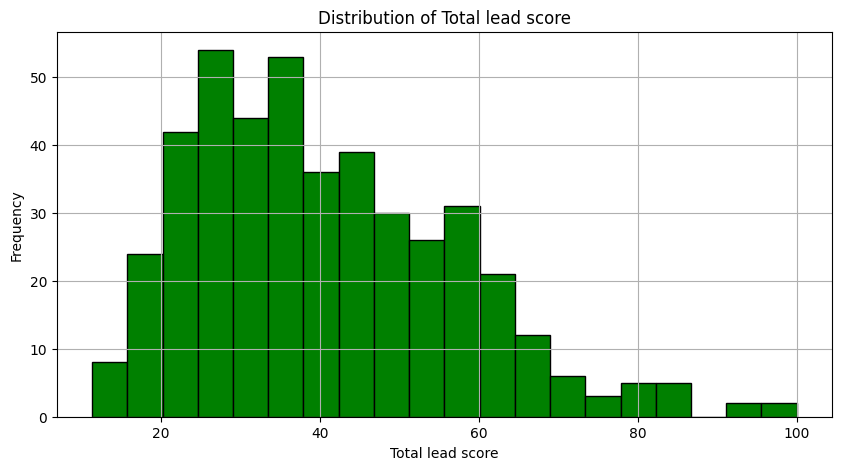

In [11]:
plt.figure(figsize=[10, 5])
plt.hist(users_lead_summary['total_lead_score'].tolist(), bins=20, color = 'green', edgecolor='black')
plt.title("Distribution of Total lead score")
plt.xlabel("Total lead score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

In [12]:
users_lead_summary['total_lead_score'].describe()

count    443.000000
mean      40.574274
std       16.508253
min       11.371237
25%       27.703456
50%       37.458194
75%       51.505017
max      100.000000
Name: total_lead_score, dtype: float64

In [14]:
for users in users_lead_summary:
    if users['total_lead_score'] < 25.0 :
        users['Lead Categoty'] = 'Not a Lead'
    elif users['total_lead_score'] > 25.0 and users['total_lead_score'] < 50.0:
        users['Lead Categoty'] = 'Low Lead'
    elif users['total_lead_score'] > 50.0 and users['total_lead_score'] < 75.0:
        users['Lead Categoty'] = 'Medium Lead'
    else:
        users['Lead Categoty'] = 'High Lead'
        

TypeError: string indices must be integers, not 'str'

In [15]:
users_lead_summary.loc[users_lead_summary['total_lead_score'] < 25.0, 'Lead Category'] = 'Not a Lead'
users_lead_summary.loc[(users_lead_summary['total_lead_score'] > 25.0) & (
        users_lead_summary['total_lead_score'] < 50.0), 'Lead Category'] = 'Low Level Lead'
users_lead_summary.loc[(users_lead_summary['total_lead_score'] > 50.0) & (
        users_lead_summary['total_lead_score'] < 75.0), 'Lead Category'] = 'Medium Level Lead'
users_lead_summary.loc[(users_lead_summary['total_lead_score'] > 75.0) & (
        users_lead_summary['total_lead_score'] < 1000.0), 'Lead Category'] = 'High Level Lead'

Lead Category
Low Level Lead       243
Medium Level Lead    106
Not a Lead            78
High Level Lead       16
Name: count, dtype: int64


<Axes: xlabel='Lead Category'>

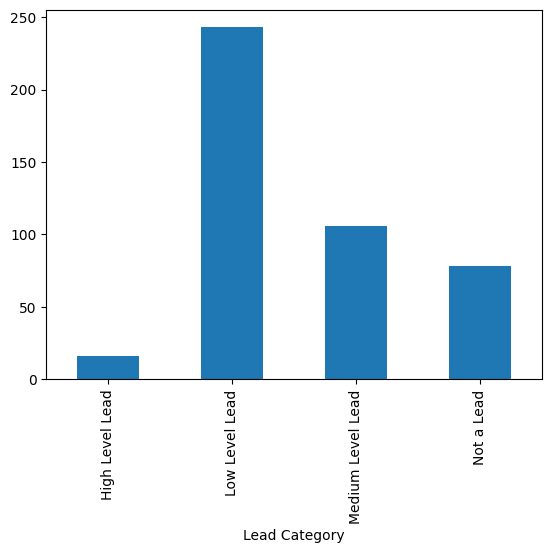

In [19]:
print(users_lead_summary['Lead Category'].value_counts().sort_values(ascending=False))
users_lead_summary['Lead Category'].value_counts().sort_index().plot(kind='bar')

In [24]:
users_lead_summary.columns

Index(['user_id', 'name', 'email', 'phone', 'age', 'gender', 'location',
       'neighborhood', 'postcode', 'income_level', 'family_status',
       'total_interactions', 'properties_viewed', 'events_tracked',
       'total_inspections', 'unique_properties_inspected',
       'total_crm_interactions', 'agents_contacted', 'most_frequent_tags',
       'unique_tags_viewed', 'most_liked_feature', 'avg_condition_rating',
       'avg_agent_interaction_rating', 'avg_inspection_satisfaction',
       'avg_likelihood_to_buy', 'engagement_score', 'inspection_score',
       'crm_score', 'property_preference_score', 'total_lead_score',
       'Lead Category'],
      dtype='object')